This notebook is structured in two main parts:
### Part 3: Anomaly and event detection
### Part 4: Feature engineer

## Part 3: Anomaly and event detection
1. Detect extreme values using statistical methods (IQR, Z-score)
2. Identify anomalies using machine learning models (Isolation Forest, One-Class SVM)
3. Analyze characteristics of detected anomalies
4. Prepare data for event pattern analysis and modeling

In [1]:
# Air quality data - Anomaly detection and analysis
# Following the result of 01_eda_and_preprocessing.ipynb

# =============================================================================
# Environment configuration and library import
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set the visual style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

print("✓ The library import was successful.")

✓ The library import was successful.


## Setup: Load preprocessed data

In [4]:
print("=== Load preprocessed data ===")

# Load the cleaned data (use the standardized version, recommended for anomaly detection)
df_clean = pd.read_csv('../data/processed/train_data_scaled.csv', 
                      index_col='DateTime', parse_dates=True)

print(f"Data shape: {df_clean.shape}")
print(f"Date range: {df_clean.index.min()} 到 {df_clean.index.max()}")

# =============================================================================
# 3. Redefine variable grouping (copied from 01_notebook)
# =============================================================================

pollutant_list = ['CO(GT)', 'NMHC(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']
sensor_list = ['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)']
meteo_vars = ['T', 'RH', 'AH']
continuous_features = pollutant_list + sensor_list + meteo_vars

print(f"Pollutant variable: {pollutant_list}")
print(f"Sensor variable: {sensor_list}")
print(f"Meteorological variable: {meteo_vars}")
print(f"Total number of continuous features: {len(continuous_features)}")

# Check the data column
print(f"\nData column: {df_clean.columns.tolist()}")
print(f"The first five rows of data:")
print(df_clean.head())

=== Load preprocessed data ===
Data shape: (7110, 18)
Date range: 2004-03-10 18:00:00 到 2004-12-31 23:00:00
Pollutant variable: ['CO(GT)', 'NMHC(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']
Sensor variable: ['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)']
Meteorological variable: ['T', 'RH', 'AH']
Total number of continuous features: 13

Data column: ['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH', 'hour', 'dayofweek', 'month', 'day_of_year', 'is_weekend']
The first five rows of data:
                       CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  PT08.S2(NMHC)  \
DateTime                                                                        
2004-03-10 18:00:00  0.321370     1.205080 -0.500870  0.165680       0.320158   
2004-03-10 19:00:00 -0.109941     0.893194 -0.770920 -0.164212      -0.023036   
2004-03-10 20:00:00  0.033830     1.397716 -0.941477 -0.

In [5]:
print("\n" + "="*50)
print("Start anomaly detection and analysis...")
print("="*50)


Start anomaly detection and analysis...


## 3.1 Detect extreme values using statistical methods (IQR, Z-score)

In [6]:
print("=== Review the completed extreme value detection ===")

# Re-run the extreme value detection to display the results
extreme_summary = []
for col in pollutant_list:
    data = df_clean[col].dropna()
    
    # IQR
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_iqr = Q1 - 1.5 * IQR
    upper_iqr = Q3 + 1.5 * IQR
    iqr_extremes = ((data < lower_iqr) | (data > upper_iqr)).sum()
    
    # Z-score
    z_scores = np.abs(stats.zscore(data))
    z_extremes = (z_scores > 3).sum()
    
    extreme_summary.append({
        'Variable': col,
        'IQR_Extremes': iqr_extremes,
        'Z_Score_Extremes': z_extremes,
        'Extreme_Rate_%': round((z_extremes / len(data)) * 100, 2)
    })

extreme_df = pd.DataFrame(extreme_summary)
print(extreme_df.to_string(index=False))

=== Review the completed extreme value detection ===
Variable  IQR_Extremes  Z_Score_Extremes  Extreme_Rate_%
  CO(GT)           206               106            1.49
NMHC(GT)            59                55            0.77
C6H6(GT)           211               103            1.45
 NOx(GT)           369               160            2.25
 NO2(GT)            83                43            0.60


## 3.2 Anomaly detection is carried out using Isolation Forest

In [7]:
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler

def isolation_forest_anomaly_detection(df, features, contamination=0.05):
    """Use Isolation Forest to detect anomalies"""
    
    print(f"=== Isolation Forest to detect anomalies ===")
    print(f"features: {features}")
    
    # prepare data
    X = df[features].copy()
    
    # standardisation 
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # train Isolation Forest
    iso_forest = IsolationForest(
        contamination=contamination, 
        random_state=42,
        n_estimators=100
    )
    
    anomalies = iso_forest.fit_predict(X_scaled)
    
    # -1 indicates abnormal and 1 indicates normal
    df_iso = df.copy()
    df_iso['is_anomaly_iso'] = anomalies
    df_iso['is_anomaly_iso'] = df_iso['is_anomaly_iso'].map({1: 0, -1: 1})  #Convert to 0/1
    
    n_anomalies = df_iso['is_anomaly_iso'].sum()
    anomaly_rate = (n_anomalies / len(df_iso)) * 100
    
    print(f"Detected outliers: {n_anomalies} ({anomaly_rate:.2f}%)")
    print(f"Pollution parameters(contamination): {contamination}")
    
    return df_iso, iso_forest, scaler

# Anomaly detection is performed using all continuous features
features_for_anomaly = continuous_features
df_with_anomalies, iso_model, anomaly_scaler = isolation_forest_anomaly_detection(
    df_clean, features_for_anomaly, contamination=0.05
)

=== Isolation Forest to detect anomalies ===
features: ['CO(GT)', 'NMHC(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)', 'PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']
Detected outliers: 356 (5.01%)
Pollution parameters(contamination): 0.05


## 3.3 One-Class SVM is used for anomaly detection

In [8]:
def one_class_svm_anomaly_detection(df, features, nu=0.05):
    """Anomaly detection using One-Class SVM"""
    
    print(f"\n=== Anomaly detection using One-Class SVM ===")
    print(f"features: {features}")
    
    # prepare data
    X = df[features].copy()
    
    # standardisation 
    scaler_svm = StandardScaler()
    X_scaled = scaler_svm.fit_transform(X)
    
    # train One-Class SVM
    oc_svm = OneClassSVM(
        nu=nu,          # The upper limit ratio of outliers
        kernel='rbf',   # Radial basis function kernel
        gamma='scale'
    )
    
    anomalies_svm = oc_svm.fit_predict(X_scaled)
    
    # -1 indicates abnormal and 1 indicates normal
    df_svm = df.copy()
    df_svm['is_anomaly_svm'] = anomalies_svm
    df_svm['is_anomaly_svm'] = df_svm['is_anomaly_svm'].map({1: 0, -1: 1})  # convert 0/1
    
    n_anomalies_svm = df_svm['is_anomaly_svm'].sum()
    anomaly_rate_svm = (n_anomalies_svm / len(df_svm)) * 100
    
    print(f"The detected anomaly points: {n_anomalies_svm} ({anomaly_rate_svm:.2f}%)")
    print(f"nu Parameter: {nu}")
    
    return df_svm, oc_svm, scaler_svm

# Use One-Class SVM
df_with_svm_anomalies, svm_model, svm_scaler = one_class_svm_anomaly_detection(
    df_clean, features_for_anomaly, nu=0.05
)


=== Anomaly detection using One-Class SVM ===
features: ['CO(GT)', 'NMHC(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)', 'PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']
The detected anomaly points: 362 (5.09%)
nu Parameter: 0.05


## 3.4 Merge the abnormal detection results and analyze them

In [9]:
def combine_anomaly_detections(df_iso, df_svm):
    """Merge the anomaly detection results of the two methods"""
    
    df_combined = df_iso.copy()
    df_combined['is_anomaly_svm'] = df_svm['is_anomaly_svm']
    
    # Create a comprehensive exception label
    df_combined['is_anomaly_combined'] = (
        (df_combined['is_anomaly_iso'] == 1) | 
        (df_combined['is_anomaly_svm'] == 1)
    ).astype(int)
    
    # Analysis of consistency
    agreement = (df_combined['is_anomaly_iso'] == df_combined['is_anomaly_svm']).mean()
    both_anomalies = ((df_combined['is_anomaly_iso'] == 1) & 
                      (df_combined['is_anomaly_svm'] == 1)).sum()
    
    print("\n=== Comparison of abnormal detection results ===")
    print(f"Isolation Forest Anomaly point: {df_combined['is_anomaly_iso'].sum()}")
    print(f"One-Class SVM Anomaly point: {df_combined['is_anomaly_svm'].sum()}")
    print(f"The outliers where the two methods are consistent: {both_anomalies}")
    print(f"Method consistency: {agreement:.1%}")
    print(f"Comprehensive outliers: {df_combined['is_anomaly_combined'].sum()}")
    
    return df_combined

# Merge results
df_final_anomalies = combine_anomaly_detections(df_with_anomalies, df_with_svm_anomalies)


=== Comparison of abnormal detection results ===
Isolation Forest Anomaly point: 356
One-Class SVM Anomaly point: 362
The outliers where the two methods are consistent: 167
Method consistency: 94.6%
Comprehensive outliers: 551


## 3.5 Visualize the results of anomaly detection

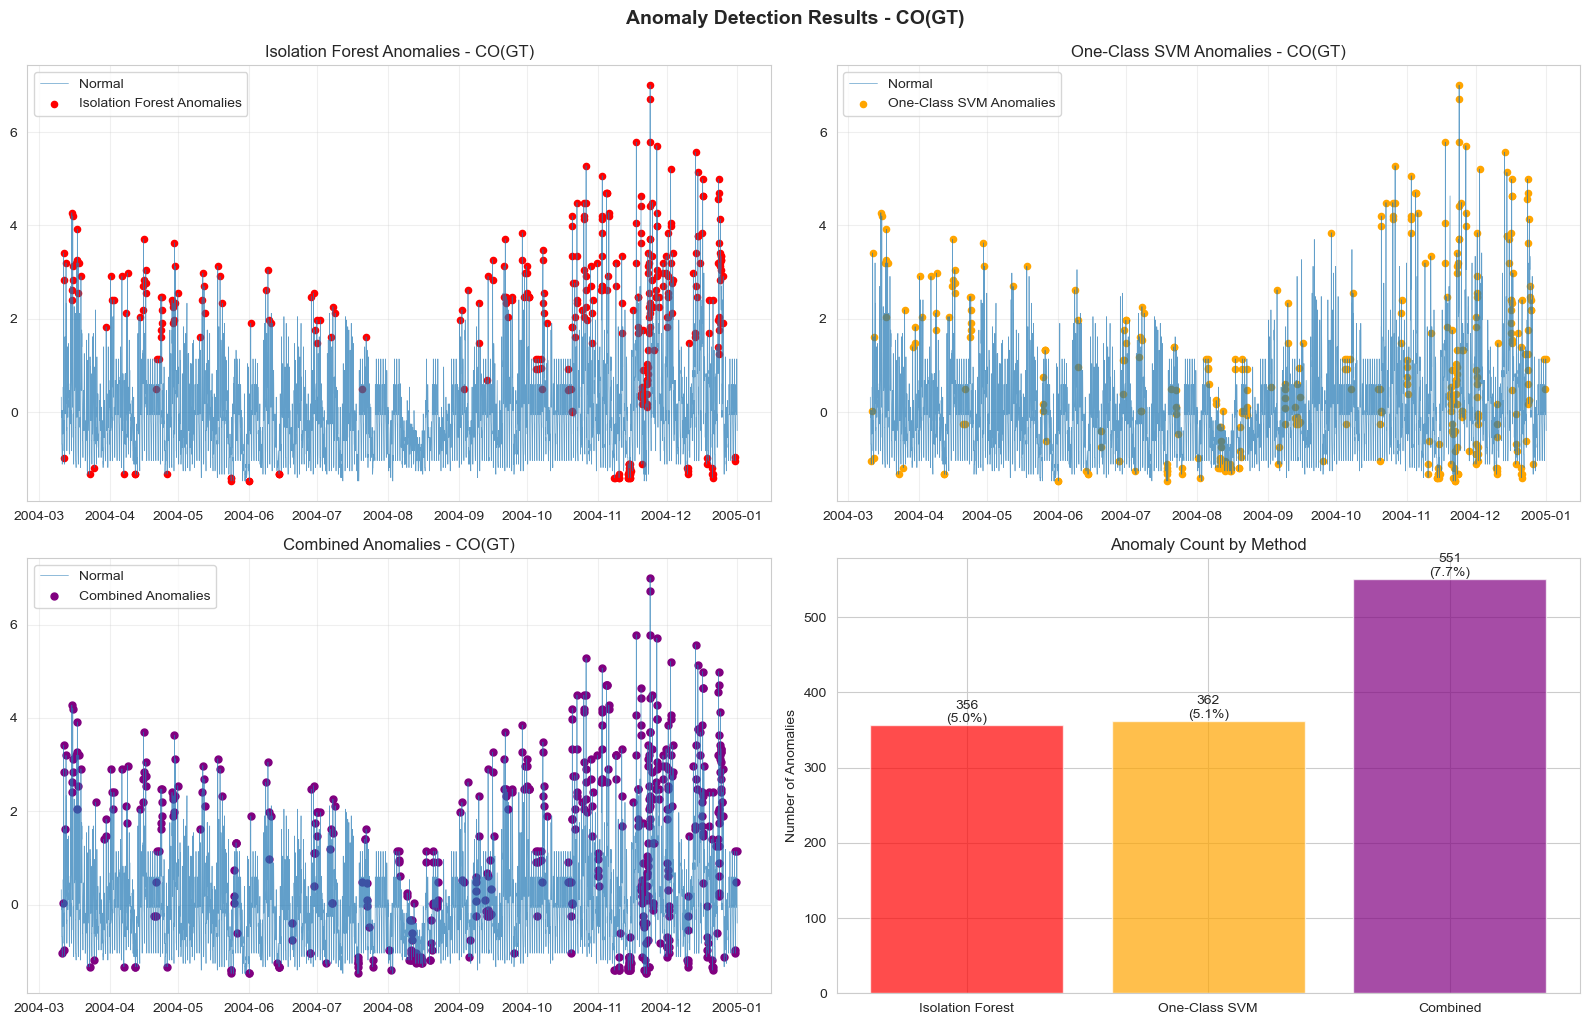

In [10]:
def visualize_anomalies(df, pollutant='CO(GT)', method='combined'):
    """Visualize the results of anomaly detection"""
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # Outliers in time series
    data = df[pollutant]
    anomalies_iso = df[df['is_anomaly_iso'] == 1]
    anomalies_svm = df[df['is_anomaly_svm'] == 1]
    anomalies_combined = df[df['is_anomaly_combined'] == 1]
    
    # Original time series + Isolation Forest exception
    axes[0, 0].plot(data.index, data.values, linewidth=0.5, alpha=0.7, label='Normal')
    axes[0, 0].scatter(anomalies_iso.index, anomalies_iso[pollutant], 
                       color='red', s=20, label='Isolation Forest Anomalies')
    axes[0, 0].set_title(f'Isolation Forest Anomalies - {pollutant}')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Original time series + One-Class SVM anomaly
    axes[0, 1].plot(data.index, data.values, linewidth=0.5, alpha=0.7, label='Normal')
    axes[0, 1].scatter(anomalies_svm.index, anomalies_svm[pollutant], 
                       color='orange', s=20, label='One-Class SVM Anomalies')
    axes[0, 1].set_title(f'One-Class SVM Anomalies - {pollutant}')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Comprehensive outliers
    axes[1, 0].plot(data.index, data.values, linewidth=0.5, alpha=0.7, label='Normal')
    axes[1, 0].scatter(anomalies_combined.index, anomalies_combined[pollutant], 
                       color='purple', s=25, label='Combined Anomalies')
    axes[1, 0].set_title(f'Combined Anomalies - {pollutant}')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Outlier statistics
    anomaly_stats = pd.DataFrame({
        'Method': ['Isolation Forest', 'One-Class SVM', 'Combined'],
        'Count': [len(anomalies_iso), len(anomalies_svm), len(anomalies_combined)],
        'Percentage': [
            len(anomalies_iso)/len(df)*100,
            len(anomalies_svm)/len(df)*100, 
            len(anomalies_combined)/len(df)*100
        ]
    })
    
    axes[1, 1].bar(anomaly_stats['Method'], anomaly_stats['Count'], 
                   color=['red', 'orange', 'purple'], alpha=0.7)
    axes[1, 1].set_title('Anomaly Count by Method')
    axes[1, 1].set_ylabel('Number of Anomalies')
    
    # Add numerical labels to the bar chart
    for i, v in enumerate(anomaly_stats['Count']):
        axes[1, 1].text(i, v, f'{v}\n({anomaly_stats["Percentage"][i]:.1f}%)', 
                       ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.suptitle(f'Anomaly Detection Results - {pollutant}', y=1.02, fontsize=14, fontweight='bold')
    plt.show()

# Visualize the abnormal detection results of CO
visualize_anomalies(df_final_anomalies, 'CO(GT)')

## 3.6 Analyze the characteristics of outliers

In [11]:
def analyze_anomaly_characteristics(df):
    """Analyze the characteristics of outliers"""
    
    print("=== Analysis of outlier characteristics ===")
    
    normal_data = df[df['is_anomaly_combined'] == 0]
    anomaly_data = df[df['is_anomaly_combined'] == 1]
    
    print(f"Normal quantity: {len(normal_data)}")
    print(f"The number of outliers: {len(anomaly_data)}")
    
    # Statistical comparison of key variables
    key_vars = ['CO(GT)', 'NOx(GT)', 'NO2(GT)', 'T', 'RH']
    
    comparison = pd.DataFrame({
        'Variable': key_vars,
        'Normal_Mean': [normal_data[var].mean() for var in key_vars],
        'Anomaly_Mean': [anomaly_data[var].mean() for var in key_vars],
        'Normal_Std': [normal_data[var].std() for var in key_vars],
        'Anomaly_Std': [anomaly_data[var].std() for var in key_vars]
    })
    
    comparison['Difference'] = comparison['Anomaly_Mean'] - comparison['Normal_Mean']
    comparison['Difference_Pct'] = (comparison['Difference'] / comparison['Normal_Mean']) * 100
    
    print("\nStatistical comparison of key variables:")
    print(comparison.round(3))
    
    # Analysis of Time Characteristics
    print("\nTime distribution of outliers:")
    time_features = ['hour', 'dayofweek', 'month', 'is_weekend']
    
    for feature in time_features:
        normal_dist = normal_data[feature].value_counts(normalize=True).sort_index()
        anomaly_dist = anomaly_data[feature].value_counts(normalize=True).sort_index()
        
        print(f"\n{feature}:")
        for val in normal_dist.index:
            normal_pct = normal_dist[val] * 100
            anomaly_pct = anomaly_dist.get(val, 0) * 100
            diff = anomaly_pct - normal_pct
            print(f"  {val}: Normal={normal_pct:.1f}%, Anomaly={anomaly_pct:.1f}%, Diff={diff:+.1f}%")
    
    return comparison

# Analyze abnormal characteristics
anomaly_comparison = analyze_anomaly_characteristics(df_final_anomalies)

=== Analysis of outlier characteristics ===
Normal quantity: 6559
The number of outliers: 551

Statistical comparison of key variables:
  Variable  Normal_Mean  Anomaly_Mean  Normal_Std  Anomaly_Std  Difference  \
0   CO(GT)       -0.116         1.383       0.792        1.834       1.499   
1  NOx(GT)       -0.113         1.350       0.789        1.877       1.463   
2  NO2(GT)       -0.071         0.848       0.905        1.540       0.919   
3        T        0.028        -0.327       0.979        1.173      -0.355   
4       RH       -0.017         0.203       0.987        1.124       0.220   

   Difference_Pct  
0       -1290.381  
1       -1290.381  
2       -1290.381  
3       -1290.381  
4       -1290.381  

Time distribution of outliers:

hour:
  0: Normal=4.4%, Anomaly=1.1%, Diff=-3.3%
  1: Normal=4.4%, Anomaly=1.6%, Diff=-2.7%
  2: Normal=4.3%, Anomaly=2.2%, Diff=-2.2%
  3: Normal=4.2%, Anomaly=3.3%, Diff=-1.0%
  4: Normal=4.1%, Anomaly=5.1%, Diff=+1.0%
  5: Normal=4.1%, Ano

## 3.7 Save the abnormal detection results

In [12]:
def save_anomaly_results(df, models):
    """Save the anomaly detection results and the model (final stable version)"""
    
    import joblib
    import json
    import numpy as np
    import os

    # Make sure the save path exists
    save_dir = '../data/processed'
    os.makedirs(save_dir, exist_ok=True)
    
    # Save the data with exception labels
    csv_path = os.path.join(save_dir, 'data_with_anomalies.csv')
    df.to_csv(csv_path, index=True)
    
    # save the anomaly detection model
    joblib.dump(models['isolation_forest'], os.path.join(save_dir, 'isolation_forest_model.pkl'))
    joblib.dump(models['one_class_svm'], os.path.join(save_dir, 'one_class_svm_model.pkl'))
    joblib.dump(models['iso_scaler'], os.path.join(save_dir, 'anomaly_scaler_iso.pkl'))
    joblib.dump(models['svm_scaler'], os.path.join(save_dir, 'anomaly_scaler_svm.pkl'))
    
    # Calculate outlier statistics
    anomaly_stats = {
        'total_samples': len(df),
        'iso_anomalies': df['is_anomaly_iso'].sum(),
        'svm_anomalies': df['is_anomaly_svm'].sum(), 
        'combined_anomalies': df['is_anomaly_combined'].sum(),
        'anomaly_rate_combined': (df['is_anomaly_combined'].sum() / len(df)) * 100
    }
    
    # Save the statistics as JSON (automatically convert to numpy type
    json_path = os.path.join(save_dir, 'anomaly_statistics.json')
    with open(json_path, 'w') as f:
        json.dump(anomaly_stats, f, indent=2, 
                  default=lambda x: x.item() if isinstance(x, (np.generic,)) else x)
    
    # Construct the summary string
    summary = (
        f"=== The abnormal detection result has been saved successfully ===\n"
        f"✓ CSV: {csv_path}\n"
        f"✓ Model: isolation_forest_model.pkl, one_class_svm_model.pkl\n"
        f"✓ Scaler: anomaly_scaler_iso.pkl, anomaly_scaler_svm.pkl\n"
        f"✓ JSON: {json_path}\n\n"
        f"Summary of Anomaly Detection:\n"
        f"  • Total sample: {anomaly_stats['total_samples']}\n"
        f"  • Comprehensive outliers: {anomaly_stats['combined_anomalies']} "
        f"({anomaly_stats['anomaly_rate_combined']:.1f}%)"
    )
    
    # print summary
    print(summary)
    
    # Return "summary" for convenient display in the Notebook
    return summary


models_to_save = {
    'isolation_forest': iso_model,
    'one_class_svm': svm_model,
    'iso_scaler': anomaly_scaler,
    'svm_scaler': svm_scaler
}

summary = save_anomaly_results(df_final_anomalies, models_to_save)
summary  

=== The abnormal detection result has been saved successfully ===
✓ CSV: ../data/processed/data_with_anomalies.csv
✓ Model: isolation_forest_model.pkl, one_class_svm_model.pkl
✓ Scaler: anomaly_scaler_iso.pkl, anomaly_scaler_svm.pkl
✓ JSON: ../data/processed/anomaly_statistics.json

Summary of Anomaly Detection:
  • Total sample: 7110
  • Comprehensive outliers: 551 (7.7%)


'=== The abnormal detection result has been saved successfully ===\n✓ CSV: ../data/processed/data_with_anomalies.csv\n✓ Model: isolation_forest_model.pkl, one_class_svm_model.pkl\n✓ Scaler: anomaly_scaler_iso.pkl, anomaly_scaler_svm.pkl\n✓ JSON: ../data/processed/anomaly_statistics.json\n\nSummary of Anomaly Detection:\n  • Total sample: 7110\n  • Comprehensive outliers: 551 (7.7%)'

## Part 4: Feature engineer
1. Create temporal features to capture time dependencies
2. Generate statistical features for pattern recognition
3. Engineer interaction features for multivariate relationships
4. Extract cyclical patterns using Fourier analysis
5. Compare different time aggregation strategies
